In [6]:
import numpy as np
import scipy.sparse as sparse
import h5py as h5
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.color
import skimage.feature
import sklearn.ensemble
from matplotlib.colors import LinearSegmentedColormap
from copy import copy, deepcopy

In [7]:
def gen_laplacian(n_pixel):
    num = n_pixel*n_pixel
    diag = np.ones(num)*4
    diag[np.arange(num)%n_pixel==0] = 3
    diag[np.arange(num)%n_pixel==n_pixel-1] = 3
    diag[:n_pixel] -= 1
    diag[-n_pixel:] -= 1
    r_diag = np.ones(num-1)*(-1)
    l_diag = np.ones(num-1)*(-1)
    r_diag[np.arange(num-1)%n_pixel==n_pixel-1] = 0
    l_diag[np.arange(num-1)%n_pixel==n_pixel-1] = 0
    t_diag = np.ones(num-n_pixel)*(-1)
    b_diag = np.ones(num-n_pixel)*(-1)
    diagonals = [t_diag, l_diag, diag, r_diag, b_diag]
    L = sparse.diags(diagonals, [-n_pixel,-1, 0, 1,n_pixel], format="csr")
    return(L)

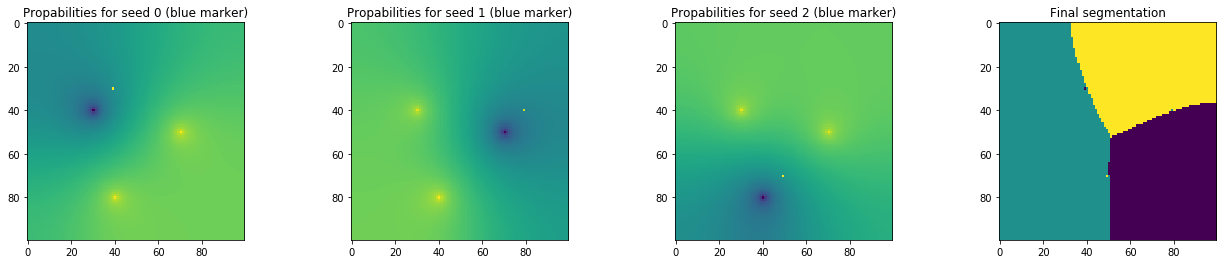

In [8]:
#EX01:

image = np.zeros((100, 100))
L = gen_laplacian(image.shape[0])   # generate the graph laplacian as a sparse matrix type
seeds = [[30, 40]
         ,[40, 80]
         ,[70, 50]]

colums = list(range(image.shape[0] * image.shape[1])) # create incrementing integer array indexing the columns of the graph laplacian
colums.remove(image.shape[0]*seeds[0][0]+seeds[0][1])  # Remove the indexes that are indexing the column of a seed
colums.remove(image.shape[0]*seeds[1][0]+seeds[1][1])
colums.remove(image.shape[0]*seeds[2][0]+seeds[2][1])
rows = list(range(image.shape[0] * image.shape[1]))   # create incrementing integer array indexing the rows of the graph laplacian
rows.remove(image.shape[0]*seeds[0][1]+seeds[0][0])    # Remove the indexes that are indexing the row of a seed
rows.remove(image.shape[0]*seeds[1][1]+seeds[1][0])
rows.remove(image.shape[0]*seeds[2][1]+seeds[2][0])

tmp = sparse.csr_matrix(L[rows,:])   # delete the colums rows that contain seeds in the graph laplacian and save it as tmp which is 10 000x9 997
A = sparse.csr_matrix(tmp[:,colums]) # from tmp delete the rows that contain seeds. Now we have a 9 997x9 997 matrix. This is the MAtrix A from our system of equations
B = np.zeros((A.shape[1] , 3))       # Create for each seed a vector b for the systems of equations

for i in range(B.shape[0]):
    B[i, 0] = tmp[i, image.shape[0]*seeds[0][0]+seeds[0][1]]   # Each vector b gets the column of the graph laplacian assigned that contains the coressponding seed. The colums do not contain the rows that contain seed. Giving us a 1x9 997 vector
    B[i, 1] = tmp[i, image.shape[0]*seeds[1][0]+seeds[1][1]]
    B[i, 2] = tmp[i, image.shape[0]*seeds[2][0]+seeds[2][1]]
    

x = []

for i in range(B.shape[1]):
    x.append(list(sparse.linalg.spsolve(A, B[:,i])))           # Now we can solve the system of equations by solving it for each vector b

# The three solutions give the propabilities for each seed but do not contain the seeds itself.
# Add the seeds to the solution
x[0].insert(image.shape[1]*seeds[0][0]+seeds[0][1]-1, 1)
x[1].insert(image.shape[1]*seeds[0][0]+seeds[0][1]-1, 0)
x[2].insert(image.shape[1]*seeds[0][0]+seeds[0][1]-1, 0)

x[0].insert(image.shape[1]*seeds[1][0]+seeds[1][1]-1, 0)
x[1].insert(image.shape[1]*seeds[1][0]+seeds[1][1]-1, 1)
x[2].insert(image.shape[1]*seeds[1][0]+seeds[1][1]-1, 0)

x[0].insert(image.shape[1]*seeds[2][0]+seeds[2][1]-1, 0)
x[1].insert(image.shape[1]*seeds[2][0]+seeds[2][1]-1, 0)
x[2].insert(image.shape[1]*seeds[2][0]+seeds[2][1]-1, 1)

x_fin = [] # vector, containing the final segmentation

for i in range(len(x[0])):
    tmp = np.array([x[0][i], x[1][i], x[2][i]])
    x_fin.append(np.argmax(tmp)) # into the final segmentation write for each pixel the seed number which has the highest propability (in x)

# Fit the propability vectors and the final segmentation vector into image dimension 100x100
propa_s0 = np.reshape(x[0],(image.shape[0],image.shape[1]))
propa_s1 = np.reshape(x[1],(image.shape[0],image.shape[1]))
propa_s2 = np.reshape(x[2],(image.shape[0],image.shape[1]))

seg = np.reshape(x_fin,(image.shape[0],image.shape[1]))

# plot the solutions
fig = plt.figure()
ax0 = fig.add_subplot(141)
ax1 = fig.add_subplot(142)
ax2 = fig.add_subplot(143)
ax3 = fig.add_subplot(144)
fig.subplots_adjust(right=3)

ax0.set_title('Propabilities for seed 0 (blue marker)')
ax0.imshow(propa_s0)
ax1.set_title('Propabilities for seed 1 (blue marker)')
ax1.imshow(propa_s1)
ax2.set_title('Propabilities for seed 2 (blue marker)')
ax2.imshow(propa_s2)
ax3.set_title('Final segmentation')
ax3.imshow(seg)